In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

np.random.seed(1)

In [8]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [9]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [10]:
# normalize the datasets
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# convert the labels to one hot vectors
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

In [11]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32,shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,shape=[None, n_y])
    
    return X, Y

In [12]:
def initialize_parameters():
    tf.set_random_seed(1)                              
    
    W1 = tf.get_variable('W1',[4, 4, 3, 8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2, 2, 8, 16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    # shuffling
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # "minibatching"
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # minibatching for the last case
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:
def forward_propagation(X, parameters):
    """
    
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC
    
    
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1,[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    # CONV2D
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2,[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # FC
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn=None)

    return Z3

In [15]:
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    
    return cost

In [16]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.005, num_epochs = 1000, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                         
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                       
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
   
    cost = compute_cost(Z3, Y)
    
    
    # Backprop
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    
    # Start tensorflow session
    with tf.Session() as sess:
        
        # Variale initialization
        sess.run(tf.global_variables_initializer())
        
        # Training
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                # optimize
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                # costs
                minibatch_cost += temp_cost / num_minibatches
                

            # Print stuffs
            if print_cost == True and epoch % 50 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
            # for plotting, gather the costs
            costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('num_iterations')
        plt.title("learning_rate : " + str(learning_rate))
        plt.show()

        
        # Calculate accuracy
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train}) * 100
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test}) * 100
        print("Train Accuracy:", train_accuracy, " %")
        print("Test Accuracy:", test_accuracy, " %")
        
        predictions_train = predict_op.eval({X: X_train})
        predictions_test = predict_op.eval({X: X_test})
                
        return train_accuracy, test_accuracy, parameters, predictions_train, predictions_test

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 1.927888
Cost after epoch 50: 0.381132
Cost after epoch 100: 0.190770
Cost after epoch 150: 0.095696
Cost after epoch 200: 0.048839
Cost after epoch 250: 0.029123
Cost after epoch 300: 0.013326
Cost after epoch 350: 0.007078
Cost after epoch 400: 0.004161
Cost after epoch 450: 0.002580
Cost after epoch 500: 0.002409
Cost after epoch 550: 0.001683
Cost after epoch 600: 0.001350
Cost after epoch 650: 0.001023
Cost after epoch 700: 0.000663
Cost after epoch 750: 0.000452
Cost after epoch 800: 0.000307
Cost after epoch 850: 0.000226
Cost after epoch 900: 0.001515
Cost after epoch 950: 0.000354


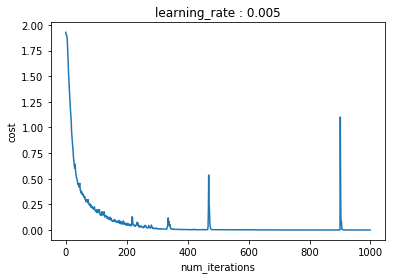

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 100.0  %
Test Accuracy: 91.66666865348816  %


In [17]:
train_accuracy, test_accuracy, parameters, predictions_train, predictions_test = model(X_train, Y_train, X_test, Y_test)

In [18]:
def verify(index, X, Y):
    print("This is : " + str(Y[index]))
    plt.imshow(X[index])

This is : 4


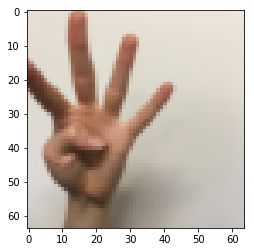

In [19]:
# pass the image index as the first parameter

verify(50, X_test_orig, predictions_test)